In [2]:
!pip install torchvision matplotlib scikit-learn

  Using cached torchvision-0.23.0-cp312-cp312-win_amd64.whl.metadata (6.1 kB)
  Using cached torch-2.8.0-cp312-cp312-win_amd64.whl.metadata (30 kB)
Using cached torchvision-0.23.0-cp312-cp312-win_amd64.whl (1.6 MB)
   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.3/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.5/241.3 MB 985.5 kB/s eta 0:04:05
   ---------------------------------------- 0.8/241.3 MB 1.0 MB/s eta 0:03:50
   ---------------------------------------- 1.0/241.3 MB 1.1 MB/s eta 0:03:40
   ---------------------------------------- 1.3/241.3 MB 1.1 MB/s eta 0:03:35
   ---------------------------------------- 1.6/241.3 MB 1.1 MB/s eta 0:03:29
   -----------------------------------

In [5]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# Set random seeds for reproducibility
torch.manual_seed(42)  # Fixed: changed maximal_seed to manual_seed
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [7]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, 
                                     download=True, transform=transform)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, 
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, 
                                         shuffle=False, num_workers=2)

100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:05<00:00, 1.79MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 1.18MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 4.79MB/s]


In [9]:
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # Input: 1x28x28, Output: 16x28x28
        self.pool = nn.MaxPool2d(2, 2)               # Reduces size by half: 16x14x14
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # Output: 32x14x14 -> after pool: 32x7x7
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)  # Flatten the tensor
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Create model instance and move to device
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Training parameters
num_epochs = 10
train_losses = []
val_accuracies = []

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training loop
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()
        
        # Print statistics
        if i % 200 == 199:
            print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss/200:.4f}')
            running_loss = 0.0
    
    # Calculate validation accuracy after each epoch
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    val_accuracies.append(accuracy)
    print(f'Epoch {epoch+1} completed. Validation Accuracy: {accuracy:.4f}')

print('Finished Training')

Starting training...
Epoch 1, Batch 200, Loss: 0.6128
Epoch 1, Batch 400, Loss: 0.2021
Epoch 1, Batch 600, Loss: 0.1474
Epoch 1, Batch 800, Loss: 0.1242
Epoch 1 completed. Validation Accuracy: 0.9788
Epoch 2, Batch 200, Loss: 0.0968
Epoch 2, Batch 400, Loss: 0.0944
Epoch 2, Batch 600, Loss: 0.0873
Epoch 2, Batch 800, Loss: 0.0776
Epoch 2 completed. Validation Accuracy: 0.9866
Epoch 3, Batch 200, Loss: 0.0680
Epoch 3, Batch 400, Loss: 0.0648
Epoch 3, Batch 600, Loss: 0.0725
Epoch 3, Batch 800, Loss: 0.0689
Epoch 3 completed. Validation Accuracy: 0.9881
Epoch 4, Batch 200, Loss: 0.0549
Epoch 4, Batch 400, Loss: 0.0571
Epoch 4, Batch 600, Loss: 0.0555
Epoch 4, Batch 800, Loss: 0.0550
Epoch 4 completed. Validation Accuracy: 0.9906
Epoch 5, Batch 200, Loss: 0.0419
Epoch 5, Batch 400, Loss: 0.0510
Epoch 5, Batch 600, Loss: 0.0496
Epoch 5, Batch 800, Loss: 0.0472
Epoch 5 completed. Validation Accuracy: 0.9903
Epoch 6, Batch 200, Loss: 0.0338
Epoch 6, Batch 400, Loss: 0.0413
Epoch 6, Batch 600

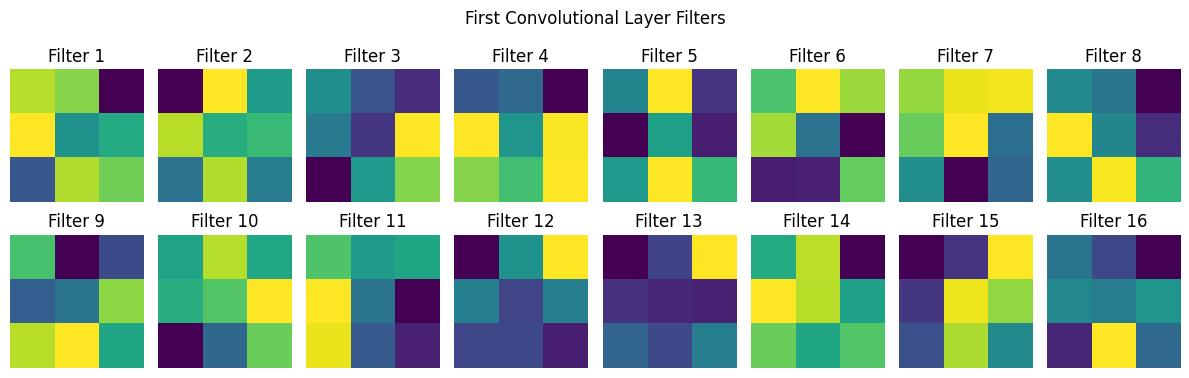

In [15]:
# Function to visualize filters
def visualize_filters(model):
    # Get the weights of the first convolutional layer
    filters = model.conv1.weight.data.cpu().numpy()
    
    # Plot the filters
    
    fig, axes = plt.subplots(2, 8, figsize=(12, 4))
    for i, ax in enumerate(axes.flat):
        if i < 16:
            filter_img = filters[i, 0]  # First channel (grayscale)
            ax.imshow(filter_img, cmap='viridis')
            ax.set_title(f'Filter {i+1}')
            ax.axis('off')
    plt.suptitle('First Convolutional Layer Filters')
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_filters(model)

In [21]:
# Function to visualize feature maps (alternative layout)
def visualize_feature_maps(model, sample_image):
    model.eval()
    
    # Hook to capture feature maps from the first convolutional layer
    feature_maps = []
    def hook_fn(module, input, output):
        feature_maps.append(output)
    
    hook = model.conv1.register_forward_hook(hook_fn)
    
    with torch.no_grad():
        _ = model(sample_image.unsqueeze(0).to(device))
    
    hook.remove()
    
    # Plot the original image and feature maps in a 3x9 grid
    fig, axes = plt.subplots(3, 6, figsize=(15, 8))
    
    # Original image (span two cells)
    axes[0, 0].imshow(sample_image.squeeze().numpy(), cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Hide the cell next to the original image
    axes[0, 1].axis('off')
    
    # Feature maps
    maps = feature_maps[0][0].cpu().numpy()
    for i in range(16):
        row = (i + 2) // 6  # Start from position 2 (after the original image)
        col = (i + 2) % 6
        axes[row, col].imshow(maps[i], cmap='viridis')
        axes[row, col].set_title(f'Map {i+1}')
        axes[row, col].axis('off')
    
    plt.suptitle('Feature Maps from First Convolutional Layer')
    plt.tight_layout()
    plt.show()

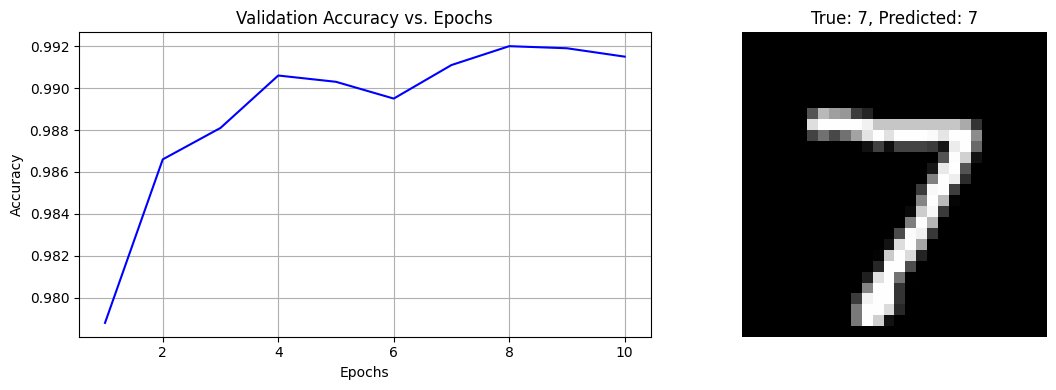

In [23]:
# Plot training results
plt.figure(figsize=(12, 4))

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), val_accuracies, 'b-')
plt.title('Validation Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# Plot sample predictions
plt.subplot(1, 2, 2)
model.eval()
with torch.no_grad():
    outputs = model(sample_image.unsqueeze(0).to(device))
    _, predicted = torch.max(outputs, 1)

plt.imshow(sample_image.squeeze().numpy(), cmap='gray')
plt.title(f'True: {sample_label[0]}, Predicted: {predicted.item()}')
plt.axis('off')

plt.tight_layout()
plt.show()

In [25]:
# Calculate final test accuracy
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
print(f'Final Test Accuracy: {final_accuracy:.4f}')

Final Test Accuracy: 0.9915


In [27]:
# Save the trained model
torch.save(model.state_dict(), 'mnist_cnn.pth')
print("Model saved as mnist_cnn.pth")

Model saved as mnist_cnn.pth
